# NYC taxi trip duration - EDA + Modeling

## Data Loading

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.pyplot import plot
from matplotlib.colors import LogNorm

%matplotlib inline
sns.set({'figure.figsize':(15,8)})

import os

In [2]:
# Load the training and testing datasets
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

## Data Exploration & Cleaning

In [3]:
# Print the first 5 rows of the traing dataset
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
# Print the first 5 rows of the testing dataset
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [5]:
# List all the training dataset features, the number of values in each and their type
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [6]:
# List all the training dataset features, the number of values in each and their type
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
id                    625134 non-null object
vendor_id             625134 non-null int64
pickup_datetime       625134 non-null object
passenger_count       625134 non-null int64
pickup_longitude      625134 non-null float64
pickup_latitude       625134 non-null float64
dropoff_longitude     625134 non-null float64
dropoff_latitude      625134 non-null float64
store_and_fwd_flag    625134 non-null object
dtypes: float64(4), int64(2), object(3)
memory usage: 42.9+ MB


We can see that the training dataset counts 11 features versus 9 for the testing dataset. The two extra features in the training dataset are "dropoff_datetime" (numerical feature) and **the target feature: "trip_duration"**. The training dataset also counts more values per feature: 1.458.644 versus 625.134 for the testing dataset.

In [7]:
# See if there are any missing values in the training dataset
for i, x in zip(list(df_train.isnull().sum().index),list(df_train.isnull().sum().values)):
    print(f"The feature {i} counts {x} missing value")

The feature id counts 0 missing value
The feature vendor_id counts 0 missing value
The feature pickup_datetime counts 0 missing value
The feature dropoff_datetime counts 0 missing value
The feature passenger_count counts 0 missing value
The feature pickup_longitude counts 0 missing value
The feature pickup_latitude counts 0 missing value
The feature dropoff_longitude counts 0 missing value
The feature dropoff_latitude counts 0 missing value
The feature store_and_fwd_flag counts 0 missing value
The feature trip_duration counts 0 missing value


In [8]:
# See if there are any missing value in the testing dataset as well
for i, x in zip(list(df_test.isnull().sum().index),list(df_test.isnull().sum().values)):
    print(f"The feature {i} counts {x} missing value")

The feature id counts 0 missing value
The feature vendor_id counts 0 missing value
The feature pickup_datetime counts 0 missing value
The feature passenger_count counts 0 missing value
The feature pickup_longitude counts 0 missing value
The feature pickup_latitude counts 0 missing value
The feature dropoff_longitude counts 0 missing value
The feature dropoff_latitude counts 0 missing value
The feature store_and_fwd_flag counts 0 missing value


In [9]:
# Now let's make sure there are no duplicated values
train_mv = df_train.duplicated().sum()
test_mv = df_test.duplicated().sum()
print(f'The training dataset counts {train_mv} duplicated value and the testing dataset counts {test_mv} as well.')

The training dataset counts 0 duplicated value and the testing dataset counts 0 as well.


#### It is not convenient to have both the date and the timing in the same cell, for the features "pickup_datetime" and "dropoff_datetime". Hence, we will split them accordingly.

In [10]:
# Split the cells content in two new features: pickup_day and pickup_time
df_train['pickup_day'] = pd.to_datetime(df_train['pickup_datetime']).dt.date
df_train['pickup_time'] = pd.to_datetime(df_train['pickup_datetime']).dt.time

# We apply this same logic to the testing set
df_test['pickup_day'] = pd.to_datetime(df_test['pickup_datetime']).dt.date
df_test['pickup_time'] = pd.to_datetime(df_test['pickup_datetime']).dt.time

# Then we do the same for the dropoff feature
df_train['dropoff_day'] = pd.to_datetime(df_train['dropoff_datetime']).dt.date
df_train['dropoff_time'] = pd.to_datetime(df_train['dropoff_datetime']).dt.time

In [11]:
# We can now drop the 'pickup_datetime' and 'dropoff_datetime' columns
df_train.drop(['pickup_datetime', 'dropoff_datetime'], axis=1, inplace=True)

df_train.shape

(1458644, 13)

In [12]:
# And while we're at it, let's not forget to drop it on the test dataframe too to maintain consistency
df_test.drop(['pickup_datetime'], axis=1, inplace=True)
df_test.shape

(625134, 10)

#### Ok, now we can take a closer look. First, let's examine our most important feature: the target one, "trip_duration". 

In [13]:
df_train['trip_duration'].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

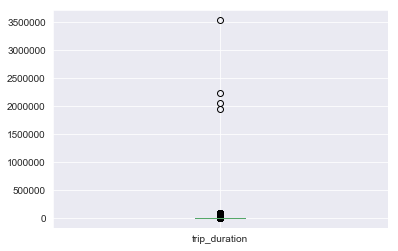

In [14]:
# Now that we now the mean and median, let's see if there are outliers
df_train.boxplot(['trip_duration']);

As we can see, we need to handle the outliers considering their extent. Let's zoom on the box to get a better look.

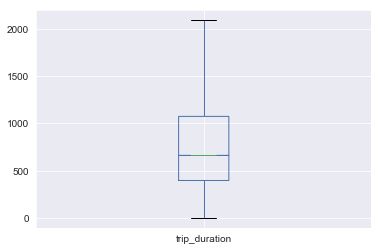

In [15]:
df_train.boxplot(['trip_duration'], showfliers=False, notch=True);

In [16]:
len(df_train.trip_duration[df_train.trip_duration > 4000].values)

8294

In [17]:
len(df_train.trip_duration[df_train.trip_duration < 10].values)

1984

We can see that most of the trip durations last between 0 and roughly 2500 seconds (approximately 46 minutes), with the highest concentration between around 800 1100 seconds, and with less than 10.000 trips with a duration over 4000 seconds (approximately 66 minutes). As a result, **we will from now on consider the trip durations over 4000 seconds as outliers** and won't take them into account in our modeling process.

Now, let's look at the latitude and longitude features, to see if they have outliers too.

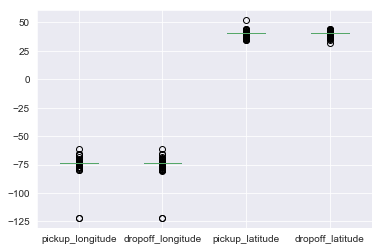

In [18]:
df_train.boxplot(['pickup_longitude', 'dropoff_longitude', 'pickup_latitude', 'dropoff_latitude']);

Seems like we have outliers here too. Let's verify.

In [19]:
len(df_train.pickup_longitude[df_train.pickup_longitude < -80].values)

2

In [20]:
len(df_train.pickup_longitude[df_train.pickup_longitude > -50].values)

0

In [21]:
len(df_train.pickup_latitude[df_train.pickup_latitude < 25].values)

0

In [22]:
len(df_train.pickup_latitude[df_train.pickup_latitude > 50].values)

1

In [23]:
# Creating our cleaned train dataset
df2_train = df_train[(df_train.trip_duration < 4000) & 
                     (df_train.pickup_longitude > -80) & 
                     (df_train.pickup_longitude < -50) &
                     (df_train.pickup_latitude > 25) &
                     (df_train.pickup_latitude < 50)
                    ]

df2_train.shape

(1450343, 13)

In [24]:
df2_train.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_time,dropoff_day,dropoff_time
0,id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17:24:55,2016-03-14,17:32:30
1,id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,00:43:35,2016-06-12,00:54:38
2,id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11:35:24,2016-01-19,12:10:48
3,id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19:32:31,2016-04-06,19:39:40
4,id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13:30:55,2016-03-26,13:38:10


In [25]:
df_test.shape, df2_train.shape

((625134, 10), (1450343, 13))

## Features Engineering

Now that we have normalized our target feature, let's plot those its points to see what their distribution looks like.

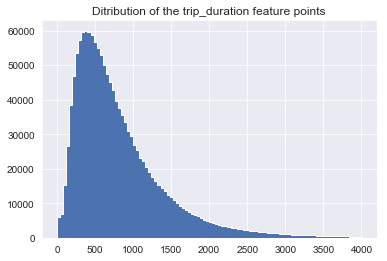

In [26]:
df2_train['trip_duration'].hist(bins=100, histtype='stepfilled')
plt.title("Ditribution of the trip_duration feature points");

This is what appears to be a **normal distribution with a left skewness**.

Let's see if we can visualize some particularly high concentrations of points in specific places.

In [27]:
min_long = -80
max_long = -50
min_lat = 25
max_lat = 50

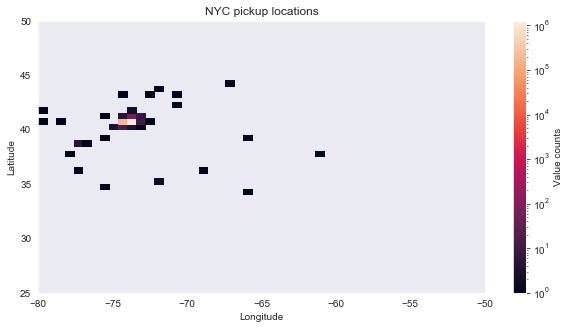

In [28]:
fig = plt.figure(1, figsize=(10,5))
hist = plt.hist2d(df2_train.pickup_longitude, df2_train.pickup_latitude, bins=50, range=[[min_long,max_long], [min_lat,max_lat]], norm=LogNorm())
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Value counts')
plt.title('NYC pickup locations')
plt.show()

One last thing, let's store the features according to their type. 

In [29]:
num_col = [
    col for col in df2_train.columns if 
    (df2_train[col].dtype=='int64' or df2_train[col].dtype=='float64') 
    and col != 'trip_duration']

num_col

['vendor_id',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude']

In [30]:
cat_col = [
    col for col in df2_train.columns if 
    (df2_train[col].dtype=='object') 
    and col != 'trip_duration']

cat_col

['id',
 'store_and_fwd_flag',
 'pickup_day',
 'pickup_time',
 'dropoff_day',
 'dropoff_time']

In [31]:
for col in cat_col:
    df2_train[col] = df2_train[col].astype('category').cat.codes
    
df2_train.head()

/Users/Skeptika/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_time,dropoff_day,dropoff_time
0,1043180,2,1,-73.982155,40.767937,-73.964630,40.765602,0,455,73,62551,73,63003
1,862740,1,1,-73.980415,40.738564,-73.999481,40.731152,0,663,163,2615,163,3278
2,1398876,2,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,18,41580,18,43701
3,1270926,2,1,-74.010040,40.719971,-74.012268,40.706718,0,429,96,70207,96,70633
4,791617,2,1,-73.973053,40.793209,-73.972923,40.782520,0,435,85,48511,85,48943


In [32]:
# Let's not forget to do the same for the test dataset
test_num_col = [
    col for col in df_test.columns if 
    (df_test[col].dtype=='int64' or df_test[col].dtype=='float64')]

test_num_col

['vendor_id',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude']

In [79]:
test_cat_col = [
    col for col in df_test.columns if 
    (df_test[col].dtype=='object')
    and col != 'id']

test_cat_col

[]

In [34]:
for col in test_cat_col:
    df_test[col] = df_test[col].astype('category').cat.codes
    
df_test.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_day,pickup_time
0,469364,1,1,-73.988129,40.732029,-73.990173,40.756680,0,181,84494
1,547621,1,1,-73.964203,40.679993,-73.959808,40.655403,0,181,84489
2,190107,1,1,-73.997437,40.737583,-73.986160,40.729523,0,181,84483
3,335483,2,1,-73.956070,40.771900,-73.986427,40.730469,0,181,84477
4,249509,1,1,-73.970215,40.761475,-73.961510,40.755890,0,181,84469


In [35]:
# Finally, we lock the target fature in a constant one
TARGET = df2_train.trip_duration

# Features Selection

In [36]:
X_train = df2_train[['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_day', 'pickup_time']]
y_train = df2_train['trip_duration']
X_train.shape, y_train.shape

((1450343, 8), (1450343,))

# Model Selection

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.2, random_state=42, stratify=y_train)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((1160274, 8), (1160274,), (290069, 8), (290069,))

In [77]:
from sklearn.ensemble import RandomForestRegressor

In [68]:
m = RandomForestRegressor(n_estimators=20, max_leaf_nodes=50000, n_jobs=-1)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=50000,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [69]:
m.score(X_valid, y_valid)

0.9036044626803564

# Model Validation & Training

In [70]:
from sklearn.model_selection import train_test_split

In [71]:
X_train_new, X_valid, y_train_new, y_valid = train_test_split(X_train, y_train, 
                                                              test_size=.2, random_state=42, stratify=y_train)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((1160274, 8), (1160274,), (232055, 8), (232055,))

Good ! Now we can cross validate our scores and start the predictions.

In [73]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(m, X_train, y_train, cv=5, scoring='neg_mean_squared_log_error')
cv_scores

array([-0.1740729 , -0.17294025, -0.17454915, -0.17181967, -0.17220008])

In [74]:
X_test = df_test[['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_day', 'pickup_time']]
y_test_pred = m.predict(X_test)
y_test_pred

array([ 746.43460846,  661.93278145,  470.79694513, ..., 1463.97978957,
       2078.88057331, 1315.18631428])

In [76]:
submission = pd.DataFrame(df_test.loc[:, 'id'])
submission['trip_duration'] = y_test_pred
print(submission.shape)
submission.head()

(625134, 2)


,id,trip_duration
0,469364,746.434608
1,547621,661.932781
2,190107,470.796945
3,335483,962.109612
4,249509,344.695161


In [78]:
submission.to_csv('submission.csv', index=False)